In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import math
import os

In [7]:
# Import the listing of block groups
block_groups_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'block_groups_nb.json')
block_groups = gpd.read_file(block_groups_path)
# Import the list of incident locations
incident_points_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'incident_points_nb.json')
incident_points = gpd.read_file(incident_points_path)

In [9]:
# Import the list of public housing locations
public_housing_locations = pd.read_excel(os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'New Bedford Housing Locations.xlsx'))
public_housing_locations.rename(columns={'Longtitude':'Longitude'},inplace=True)
# Add a proper geometric object to each row so we can plot these locations
public_housing_locations['shapely.geometry.Point'] = public_housing_locations.apply(lambda x: Point(x['Longitude'],x['Latitude']), axis=1)

In [10]:
# Calculate the approximate distance (in miles) between two points based on their longitudes and latitudes
# Needed info on the Earth's radius -- came from https://rechneronline.de/earth-radius/
# Formula used comes from https://en.wikipedia.org/wiki/Haversine_formula#Formulation
def haversine_distance(point1, point2):
    ''' Calculate the distance between two points based on latitude and longitude.
        input: two shapely.geometry.Point objects
        output: float distance (in miles)
    '''
    # Need to convert lat/long to radians for this to work
    point1_lat = point1.y * math.pi / 180
    point1_long = point1.x * math.pi / 180
    point2_lat = point2.y * math.pi / 180
    point2_long = point2.x * math.pi / 180
    # Uses the well-known Haversine formula (not perfect, but a pretty good approximation)
    inner_term = math.sin((point2_lat - point1_lat)/2)**2 + math.cos(point1_lat) * math.cos(point2_lat) * \
         math.sin((point2_long - point1_long)/2) ** 2
    distance = 2 * 3957.52 * math.asin(inner_term ** 0.5)
    return distance

In [11]:
# Find the number of incidents that occurred within x miles of a particular point
def incidents_within_radius(point, incidents, radius):
    distances_to_point = incidents.apply(lambda x: haversine_distance(x[0], point),axis=1)
    return (distances_to_point[distances_to_point <= radius]).count()

In [12]:
# For each public housing location, figure out how many incidents occurred within a certain radius of it
public_housing_locations['Incidents Within 0.1 Miles'] = public_housing_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.1),axis=1)
public_housing_locations['Incidents Within 0.25 Miles'] = public_housing_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.25),axis=1)
public_housing_locations['Incidents Within 0.5 Miles'] = public_housing_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.5),axis=1)

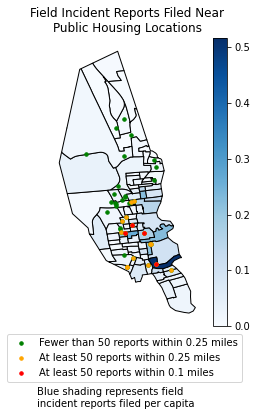

In [13]:
# On a single map, we'll do an initial plot containing just the coordinates of public housing locations
incident_radius_figure = plt.figure()
ir_axes = incident_radius_figure.add_axes([0,0,0.5,1])

# Grab the list of Point objects from the public housing locations
ph_points = gpd.GeoSeries(public_housing_locations['shapely.geometry.Point'])

# Set up a GeoPandas Coordinate Reference System for the incident locations, in order to match it with the map of New Bedford
ph_points_crs = ph_points.set_crs(crs=block_groups.crs)

# Now, make the full plot
ir_plot = block_groups.plot(column='Incidents Per Capita',cmap='Blues',edgecolor='black',axes=ir_axes,legend=True)
ph_points.plot(ax=ir_axes, marker="o",color='green',markersize=12,label='Fewer than 50 reports within 0.25 miles')

geq_50_in_quarter_mile = ph_points[public_housing_locations['Incidents Within 0.25 Miles']>=50]
geq_50_in_quarter_mile.plot(ax=ir_axes,marker="o",color='orange',markersize=12,label='At least 50 reports within 0.25 miles')

geq_50_in_tenth_of_mile = ph_points[public_housing_locations['Incidents Within 0.1 Miles']>=50]
geq_50_in_tenth_of_mile.plot(ax=ir_axes,marker="o",color='red',markersize=12,label='At least 50 reports within 0.1 miles')

ir_axes.legend(bbox_to_anchor=[1.2,-0.11,0.1,0.1])

ir_axes.set_title('Field Incident Reports Filed Near\nPublic Housing Locations')
ir_axes.axis('off')
ir_axes.text(x=-0.1,y=-0.28,s='Blue shading represents field\nincident reports filed per capita',transform=ir_axes.transAxes)
incident_radius_figure.show()

## Figure out the names that correspond to each of the four properties in red on the above graph

In [19]:
# Public housing locations with the most incidents
hotspot_locations = public_housing_locations.sort_values(by='Incidents Within 0.1 Miles',ascending=False).head()

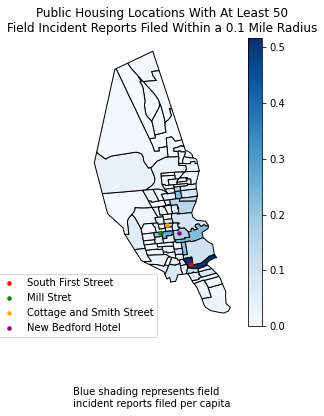

In [28]:
# Make one more map with the four "hotspots" labeled, so I'll know which dot corresponds to which location
# when I'm labeling the above graph in the final report
hotspots_figure = plt.figure()
hotspots_axes = hotspots_figure.add_axes([0,0,0.5,1])

# Grab the list of Point objects from the public housing locations
ph_points = gpd.GeoSeries(public_housing_locations['shapely.geometry.Point'])

# Set up a GeoPandas Coordinate Reference System for the incident locations, in order to match it with the map of New Bedford
ph_points_crs = ph_points.set_crs(crs=block_groups.crs)

# Now, make the full plot
hotspots_plot = block_groups.plot(column='Incidents Per Capita',cmap='Blues',edgecolor='black',axes=hotspots_axes,legend=True)

hotspot_1 = ph_points[public_housing_locations['Incidents Within 0.1 Miles']==307]
hotspot_1.plot(ax=hotspots_axes,marker="o",color='red',markersize=12,label=hotspot_locations.iloc[0]['Name'])

hotspot_2 = ph_points[public_housing_locations['Incidents Within 0.1 Miles']==78]
hotspot_2.plot(ax=hotspots_axes,marker="o",color='green',markersize=12,label=hotspot_locations.iloc[1]['Name'])

hotspot_3 = ph_points[public_housing_locations['Incidents Within 0.1 Miles']==64]
hotspot_3.plot(ax=hotspots_axes,marker="o",color='orange',markersize=12,label=hotspot_locations.iloc[2]['Name'])

hotspot_4 = ph_points[public_housing_locations['Incidents Within 0.1 Miles']==63]
hotspot_4.plot(ax=hotspots_axes,marker="o",color='purple',markersize=12,label=hotspot_locations.iloc[3]['Name'])

hotspots_axes.legend(bbox_to_anchor=[0.4,0.1,0.1,0.1])

hotspots_axes.set_title('Public Housing Locations With At Least 50\nField Incident Reports Filed Within a 0.1 Mile Radius')
hotspots_axes.axis('off')
hotspots_axes.text(x=-0.1,y=-0.28,s='Blue shading represents field\nincident reports filed per capita',transform=hotspots_axes.transAxes)
hotspots_figure.show()

## Finish off this analysis by getting some summary numbers

In [104]:
# Print some summary numbers about how many incidents happened near public housing properties
# This requires checking every single one of the 4997 incidents to see if it occurred near any public housing property
within_tenth_of_mile = [False for i in range(4997)]
within_quarter_of_mile = [False for i in range(4997)]
within_half_of_mile = [False for i in range(4997)]
incident_points['Within 0.1 Miles of Public Housing'] = within_tenth_of_mile
incident_points['Within 0.25 Miles of Public Housing'] = within_quarter_of_mile
incident_points['Within 0.5 Miles of Public Housing'] = within_half_of_mile
for i in incident_points.index:
    for j in public_housing_locations.index:
        dist = haversine_distance(incident_points.iloc[i]['geometry'],public_housing_locations.iloc[j]['shapely.geometry.Point'])
        if dist <= 0.1:
            incident_points.at[i,'Within 0.1 Miles of Public Housing'] = True
            incident_points.at[i,'Within 0.25 Miles of Public Housing'] = True
            incident_points.at[i,'Within 0.5 Miles of Public Housing'] = True
            break
        elif dist <= 0.25:
            incident_points.at[i,'Within 0.1 Miles of Public Housing'] = False
            incident_points.at[i,'Within 0.25 Miles of Public Housing'] = True
            incident_points.at[i,'Within 0.5 Miles of Public Housing'] = True
        elif dist <= 0.5:
            if incident_points.iloc[i]['Within 0.25 Miles of Public Housing'] == True:
                continue
            incident_points.at[i,'Within 0.1 Miles of Public Housing'] = False
            incident_points.at[i,'Within 0.25 Miles of Public Housing'] = False
            incident_points.at[i,'Within 0.5 Miles of Public Housing'] = True
        else:
            continue

In [108]:
# Get the final summary statistics about how many incidents occurred near public housing properties
print('Proportion of incidents within 0.1 miles of public housing:')
print(incident_points['Within 0.1 Miles of Public Housing'].sum() / 4997)
print('Proportion of incidents within 0.25 miles of public housing:')
print(incident_points['Within 0.25 Miles of Public Housing'].sum() / 4997)
print('Proportion of incidents within 0.5 miles of public housing:')
print(incident_points['Within 0.5 Miles of Public Housing'].sum() / 4997)

Proportion of incidents within 0.1 miles of public housing:
0.13608164898939365
Proportion of incidents within 0.25 miles of public housing:
0.5581348809285571
Proportion of incidents within 0.5 miles of public housing:
0.9261556934160496
